<a href="https://colab.research.google.com/github/atul1234anand/fastai/blob/master/2way.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

#Extracting data

We extract the Liar-Plus dataset as show below. We create 3 files 'train.csv', 'test.csv' and 'val.csv'. Since we want to create a binary classification, we have to categorise 'pants-fire', 'mostly-false' and 'false' as 'False' and 'barely-true', 'half-true', 'mostly-true' and 'true as 'True'.

In [3]:
!git clone https://github.com/Tariq60/LIAR-PLUS.git

Cloning into 'LIAR-PLUS'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 77 (delta 2), reused 0 (delta 0), pack-reused 68
Unpacking objects: 100% (77/77), done.


In [0]:
path = Path('/content/LIAR-PLUS/dataset')

In [5]:
path.ls()

[PosixPath('/content/LIAR-PLUS/dataset/test2.tsv'),
 PosixPath('/content/LIAR-PLUS/dataset/val2.tsv'),
 PosixPath('/content/LIAR-PLUS/dataset/train2.tsv')]

In [0]:
data_F1 = pd.read_csv('/content/LIAR-PLUS/dataset/train2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])
data_F2 = pd.read_csv('/content/LIAR-PLUS/dataset/test2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])
data_F3 = pd.read_csv('/content/LIAR-PLUS/dataset/val2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])

In [0]:
data_F1 = data_F1.replace(to_replace =['pants-fire','mostly-false','false'],  value ="false")
data_F1 = data_F1.replace(to_replace =['half-true','mostly-true','true','barely-true'],  value ="true")

data_F2 = data_F2.replace(to_replace =['pants-fire','mostly-false','false'],  value ="false")
data_F2 = data_F2.replace(to_replace =['half-true','mostly-true','true','barely-true'],  value ="true")

data_F3 = data_F3.replace(to_replace =['pants-fire','mostly-false','false'],  value ="false")
data_F3 = data_F3.replace(to_replace =['half-true','mostly-true','true','barely-true'],  value ="true")

In [0]:
data_F1.to_csv('/content/LIAR-PLUS/dataset/train.csv') 
data_F2.to_csv('/content/LIAR-PLUS/dataset/test.csv') 
data_F3.to_csv('/content/LIAR-PLUS/dataset/val.csv') 

# Building the classifier

We begin our problem of classifying the given dataset into the 2 mentioned categories. Here Im using the [ULMfit](https://arxiv.org/abs/1801.06146) algorithm.

The ULMFit algorithm is as follows:


1.   Create (or, preferred, download a pre-trained) language model trained on a large corpus.
2.   Fine-tune this language model using your target corpus.
3.   Saving and using the encoder by passing it into a classifier.

**Step1: Building the language model**

We build our language model on the AWD_LTSM architecture which uses the WikiText-2 corpus.
This starts with building that Langauage Model databunch. We compute the learning rate graphically, fit the data and save the encoder.

In [0]:
data_lm = TextLMDataBunch.from_csv(path,'train.csv')

In [0]:
data_lm.save('data_lm.pkl')

In [0]:
bs = 10
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [13]:

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


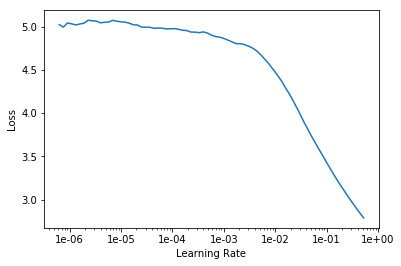

In [14]:
learn.recorder.plot(skip_end=15)

In [15]:
learn.fit_one_cycle(1, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.297149,0.226630,0.907460,00:07


In [0]:
learn.unfreeze()

In [17]:
learn.fit_one_cycle(10, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.222493,0.216442,0.907302,00:09
1,0.212870,0.199873,0.907302,00:08
2,0.236900,0.677657,0.758571,00:08
3,0.285138,0.212020,0.906984,00:08
4,0.240686,0.204275,0.906825,00:08
5,0.221579,0.202029,0.906825,00:08
6,0.211071,0.203757,0.906825,00:08
7,0.205405,0.202135,0.906825,00:08
8,0.203000,0.202679,0.906825,00:08
9,0.201692,0.203388,0.906825,00:09


In [0]:
learn.save_encoder('fine_tuned_enc')


**Step2:Pairing the classifier with the language model**

For building the classifier, we crearte a  data bunch and the language model's encoder. We then graphically analyse the learning rate  and train the model. Here we use the test.csv and val.csv files previously created to test the model.  

**Using the test.csv file as testing data**

In [0]:
data_class = TextDataBunch.from_csv(path, 'train.csv',vocab = data_lm.vocab,test = 'test.csv',text_cols = 'text',label_cols = 'label')

In [20]:
data_class.show_batch()

text,target
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk,True
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,True
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk true xxunk xxunk,True
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,True
xxbos xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,True


In [0]:
data_class.save('data_class.pkl')
data_clas = load_data(path, 'data_class.pkl', bs=bs)

In [0]:
learner = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learner.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


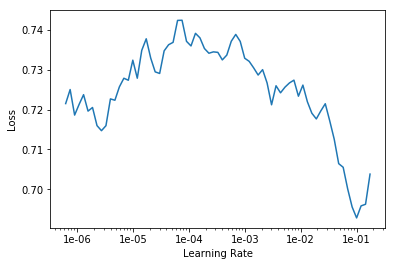

In [23]:
learner.lr_find()
learner.recorder.plot(skip_end=15)

In [24]:
learner.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.605145,0.601073,0.715959,00:43
1,0.590338,0.593824,0.715959,00:44


In [25]:
learner.save('first')
learner.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8191 items)
x: TextList
xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxup xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk
y: CategoryList
True,True,True,False,True
Path: /content/LIAR-PLUS/dataset;

Valid: LabelList (2049 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk 

In [26]:
learner.freeze_to(-2)
learner.fit_one_cycle(2,1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.606370,0.596609,0.715959,00:52
1,0.588812,0.593503,0.716447,00:49


In [27]:
learner.save('second')
learner.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8191 items)
x: TextList
xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxup xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk
y: CategoryList
True,True,True,False,True
Path: /content/LIAR-PLUS/dataset;

Valid: LabelList (2049 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk 

In [28]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.580451,0.596431,0.716447,01:16


In [29]:
learner.unfreeze()
learner.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.576473,0.599473,0.715959,01:39
1,0.600713,0.596752,0.715959,01:33
2,0.603123,0.596202,0.715959,01:38
3,0.609924,0.593462,0.716935,01:33
4,0.586281,0.593470,0.717423,01:41


**Using the val.csv file as testing data**

In [0]:
data_val = TextDataBunch.from_csv(path, 'train.csv',vocab = data_lm.vocab,test = 'val.csv',text_cols = 'text',label_cols = 'label')

In [31]:
data_class.show_batch()

text,target
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk,True
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxup xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk,False
xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk,True
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,True
xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,True


In [0]:
data_val.save('data_val.pkl')
data_val = load_data(path, 'data_val.pkl', bs=bs)

In [0]:
learner1 = text_classifier_learner(data_val, AWD_LSTM, drop_mult=0.5)
learner1.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


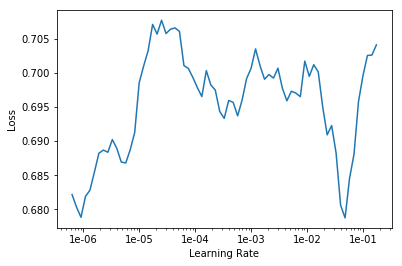

In [34]:
learner1.lr_find()
learner1.recorder.plot(skip_end=15)

In [35]:
learner1.fit_one_cycle(2, 2*1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.592878,0.591060,0.723280,00:47
1,0.574866,0.588426,0.723280,00:44


In [36]:
learner1.save('first')
learner1.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8191 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk,xxbos xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk,xxbos xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk
y: CategoryList
True,True,False,False,False
Path: /content/LIAR-PLUS/dataset;

Valid: LabelList (2049 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk,xxbos xxm

In [37]:
learner1.freeze_to(-2)
learner1.fit_one_cycle(1, 2*1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.574048,0.588635,0.723280,00:51


In [38]:
learner1.save('second')
learner1.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8191 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk,xxbos xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk,xxbos xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk
y: CategoryList
True,True,False,False,False
Path: /content/LIAR-PLUS/dataset;

Valid: LabelList (2049 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk,xxbos xxm

In [39]:
learner1.freeze_to(-3)
learner1.fit_one_cycle(1,2*1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.597422,0.590653,0.723280,01:16


In [40]:
learner1.save('third')
learner1.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8191 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk,xxbos xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk,xxbos xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk
y: CategoryList
True,True,False,False,False
Path: /content/LIAR-PLUS/dataset;

Valid: LabelList (2049 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk,xxbos xxm

In [41]:
learner1.unfreeze()
learner1.fit_one_cycle(5,2*1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.583480,0.590081,0.723280,01:33
1,0.599899,0.591372,0.723280,01:40
2,0.609776,0.595110,0.723280,01:40
3,0.581839,0.588466,0.723280,01:41
4,0.596285,0.589748,0.723280,01:40
